In [2]:
import os
from cognite.client import CogniteClient
from getpass import getpass
project = "publicdata"
api_url = f"/api/playground/projects/{project}/context/pnidobjects"
api_key = getpass("Open Industrial Data API-KEY: ")
c = CogniteClient(api_key=api_key,
                       project=project, client_name="pnid demo")

Open Industrial Data API-KEY:  ················································


/opt/conda/lib/python3.7/site-packages/cognite/client/_cognite_client.py:67: UserWarning: You are using version 2.4.2 of the SDK, however version 2.4.3 is available. Upgrade or set the environment variable 'COGNITE_DISABLE_PYPI_VERSION_CHECK' to suppress this warning.
  debug=debug,


## Import utils for demo purpose only

In [3]:
!pip install pdf2image
!pip install bounding-box
from PIL import Image
import numpy as np
from pdf2image import convert_from_path
from bounding_box import bounding_box as bb
import json
import time
import pprint
pp = pprint.PrettyPrinter(indent=2)

def draw_bbox(pnid_img, result):
    img_arr = np.array(pnid_img)
    height, width = img_arr.shape[:-1]
    img_arr_copy = img_arr[:,:,::-1].copy()
    for obj in result:
        bbox = obj["boundingBox"]
        label = obj["type"]
        bb.add(
            img_arr_copy,
            int(bbox["xMin"]*width), 
            int(bbox["yMin"]*height),
            int(bbox["xMax"]*width),
            int(bbox["yMax"]*height),
            label,
            "red"
        )
    return Image.fromarray(img_arr_copy[:,:,::-1])

  Using cached pdf2image-1.14.0-py3-none-any.whl (10 kB)
Processing /home/jovyan/.cache/pip/wheels/6a/6b/da/71d602e245ef4e78132ddf9b1fe445aca0f834d9216768a818/bounding_box-0.1.3-cp37-none-any.whl


In [13]:
c.files.list(mime_type="application/pdf").to_pandas().head()

name     source         mimeType  \
0        PH-ME-P-0156-001.pdf  Discovery  application/pdf   
1  PH-25578-P-4110119-001.pdf  Discovery  application/pdf   
2        PH-ME-P-0152-001.pdf  Discovery  application/pdf   
3        PH-ME-P-0004-001.pdf  Discovery  application/pdf   
4        PH-ME-P-0156-002.pdf  Discovery  application/pdf   

                                            metadata         dataSetId  \
0  {'__COGNITE_PNID': 'true', '__COGNITE_PNID_PAR...  2452112635370053   
1  {'__COGNITE_PNID': 'true', '__COGNITE_PNID_PAR...  2452112635370053   
2  {'__COGNITE_PNID': 'true', '__COGNITE_PNID_PAR...  2452112635370053   
3  {'__COGNITE_PNID': 'true', '__COGNITE_PNID_PAR...  2452112635370053   
4  {'__COGNITE_PNID': 'true', '__COGNITE_PNID_PAR...  2452112635370053   

                 id  uploaded   uploadedTime    createdTime  lastUpdatedTime  
0   230063753840368      True  1586949730690  1586949728738    1587127451418  
1  1173477928867194      True  1586949730124  1586949728733    1587127411349  
2  1296220000699223      True  1586949730652  1586949728743    1587127447626  
3  2240135229528595      True  1586949729424  1586949728742    1587127486739  
4  2694497441923100      True  1586949730695  1586949728743    1587127549067

## Download the P&ID to visualize

In [4]:
file_id = 230063753840368
res = c.files.retrieve(id=file_id)
print(res.name)
c.files.download_to_path(f"./{res.name}.pdf", id=res.id)

PH-ME-P-0156-001.pdf


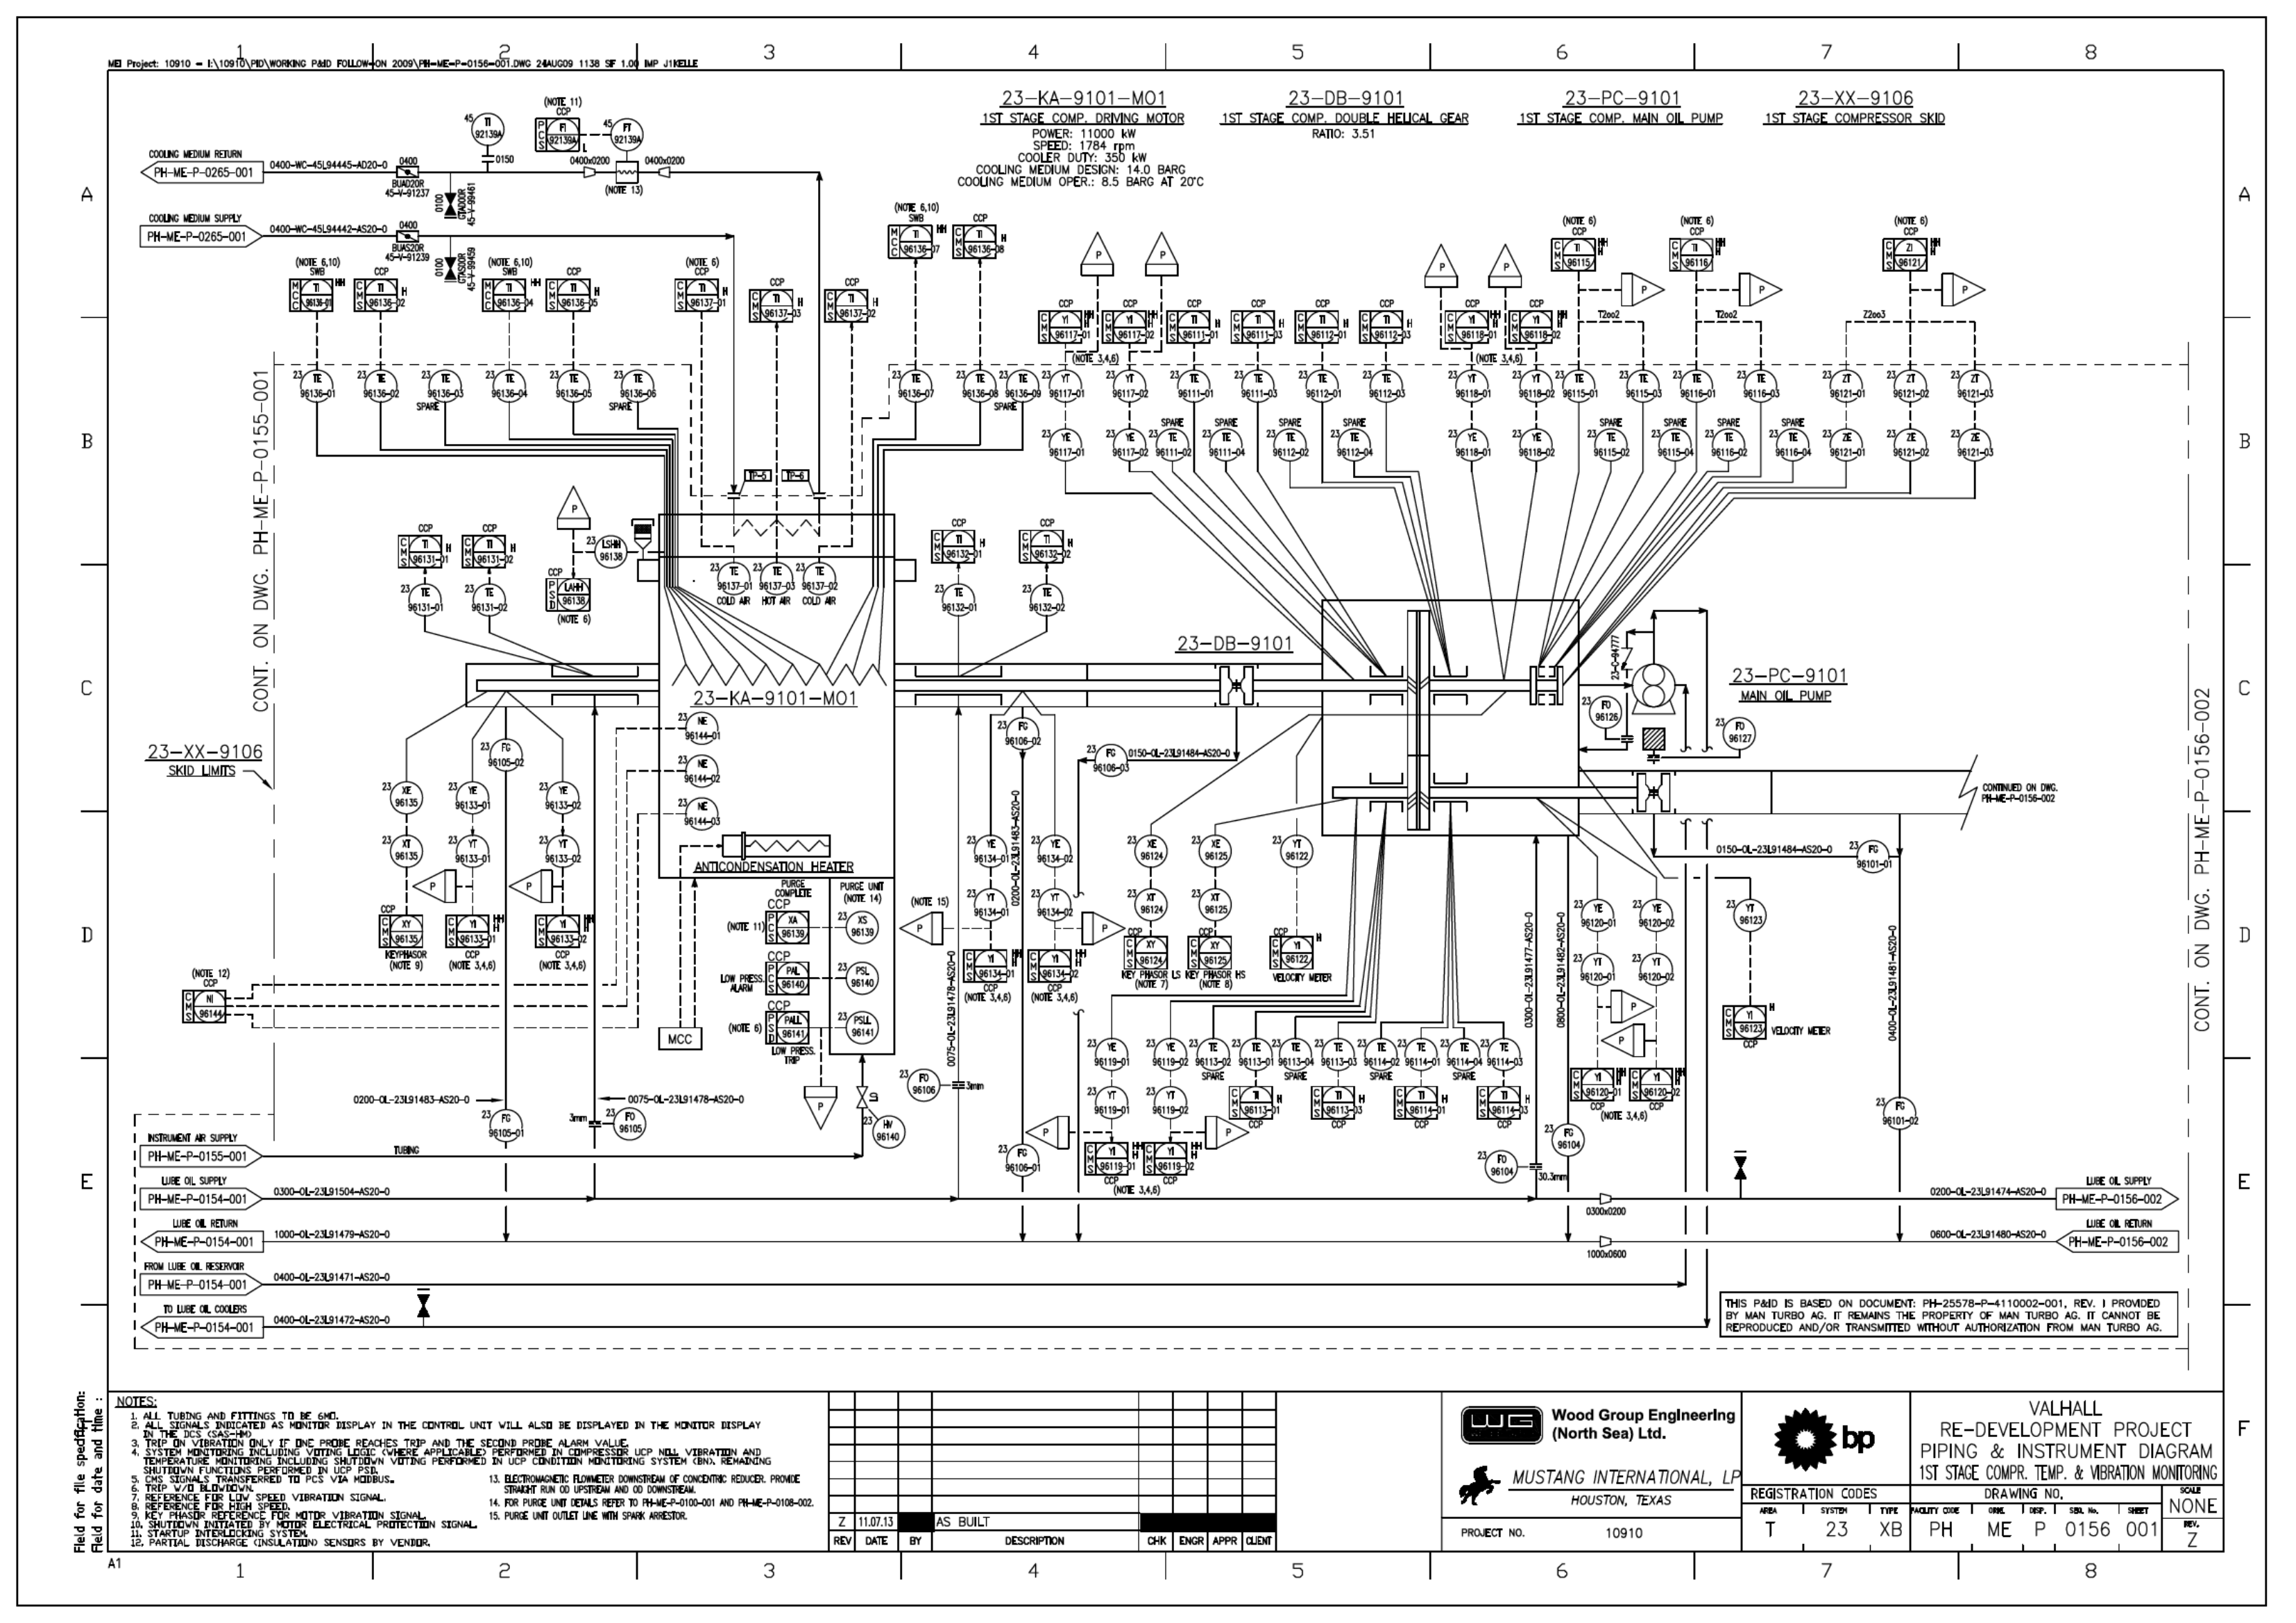

In [5]:
pnid_img = convert_from_path(f"./{res.name}.pdf")[0]
pnid_img

## Find common objects from P&ID files
We support finding 20 common shapes/objects from P&IDs using the endpoint `/findobjects` with one argument `fileId`

In [6]:
findobjects_url = f"{api_url}/findobjects"
post_body = {"fileId": file_id}
res = c.post(url = findobjects_url, json = post_body)
job_id = json.loads(res.text)["jobId"]
print("jobId:", job_id)

jobId: 8964082962164164


In [7]:
%%time
res = c.get(url = f"{api_url}/{job_id}")

while json.loads(res.text)["status"] not in ["Completed", "Failed"]:
    time.sleep(5)
    print(json.loads(res.text)["status"])
    res = c.get(url = f"{api_url}/{job_id}")


result = json.loads(res.text)["items"]
print(f"found {len(result)} objects")
print("The first object parameters:")
pp.pprint(result[0])

Queued
Running
Running
Running
Running
Running
Running
Running
Running
Running
found 208 objects
The first object parameters:
{ 'boundingBox': { 'xMax': 0.3947058823529412,
                   'xMin': 0.37970588235294117,
                   'yMax': 0.7079866888519135,
                   'yMin': 0.6863560732113144},
  'score': 0.9998923540115356,
  'type': 'indicator'}
CPU times: user 51.7 ms, sys: 7.72 ms, total: 59.4 ms
Wall time: 50.8 s


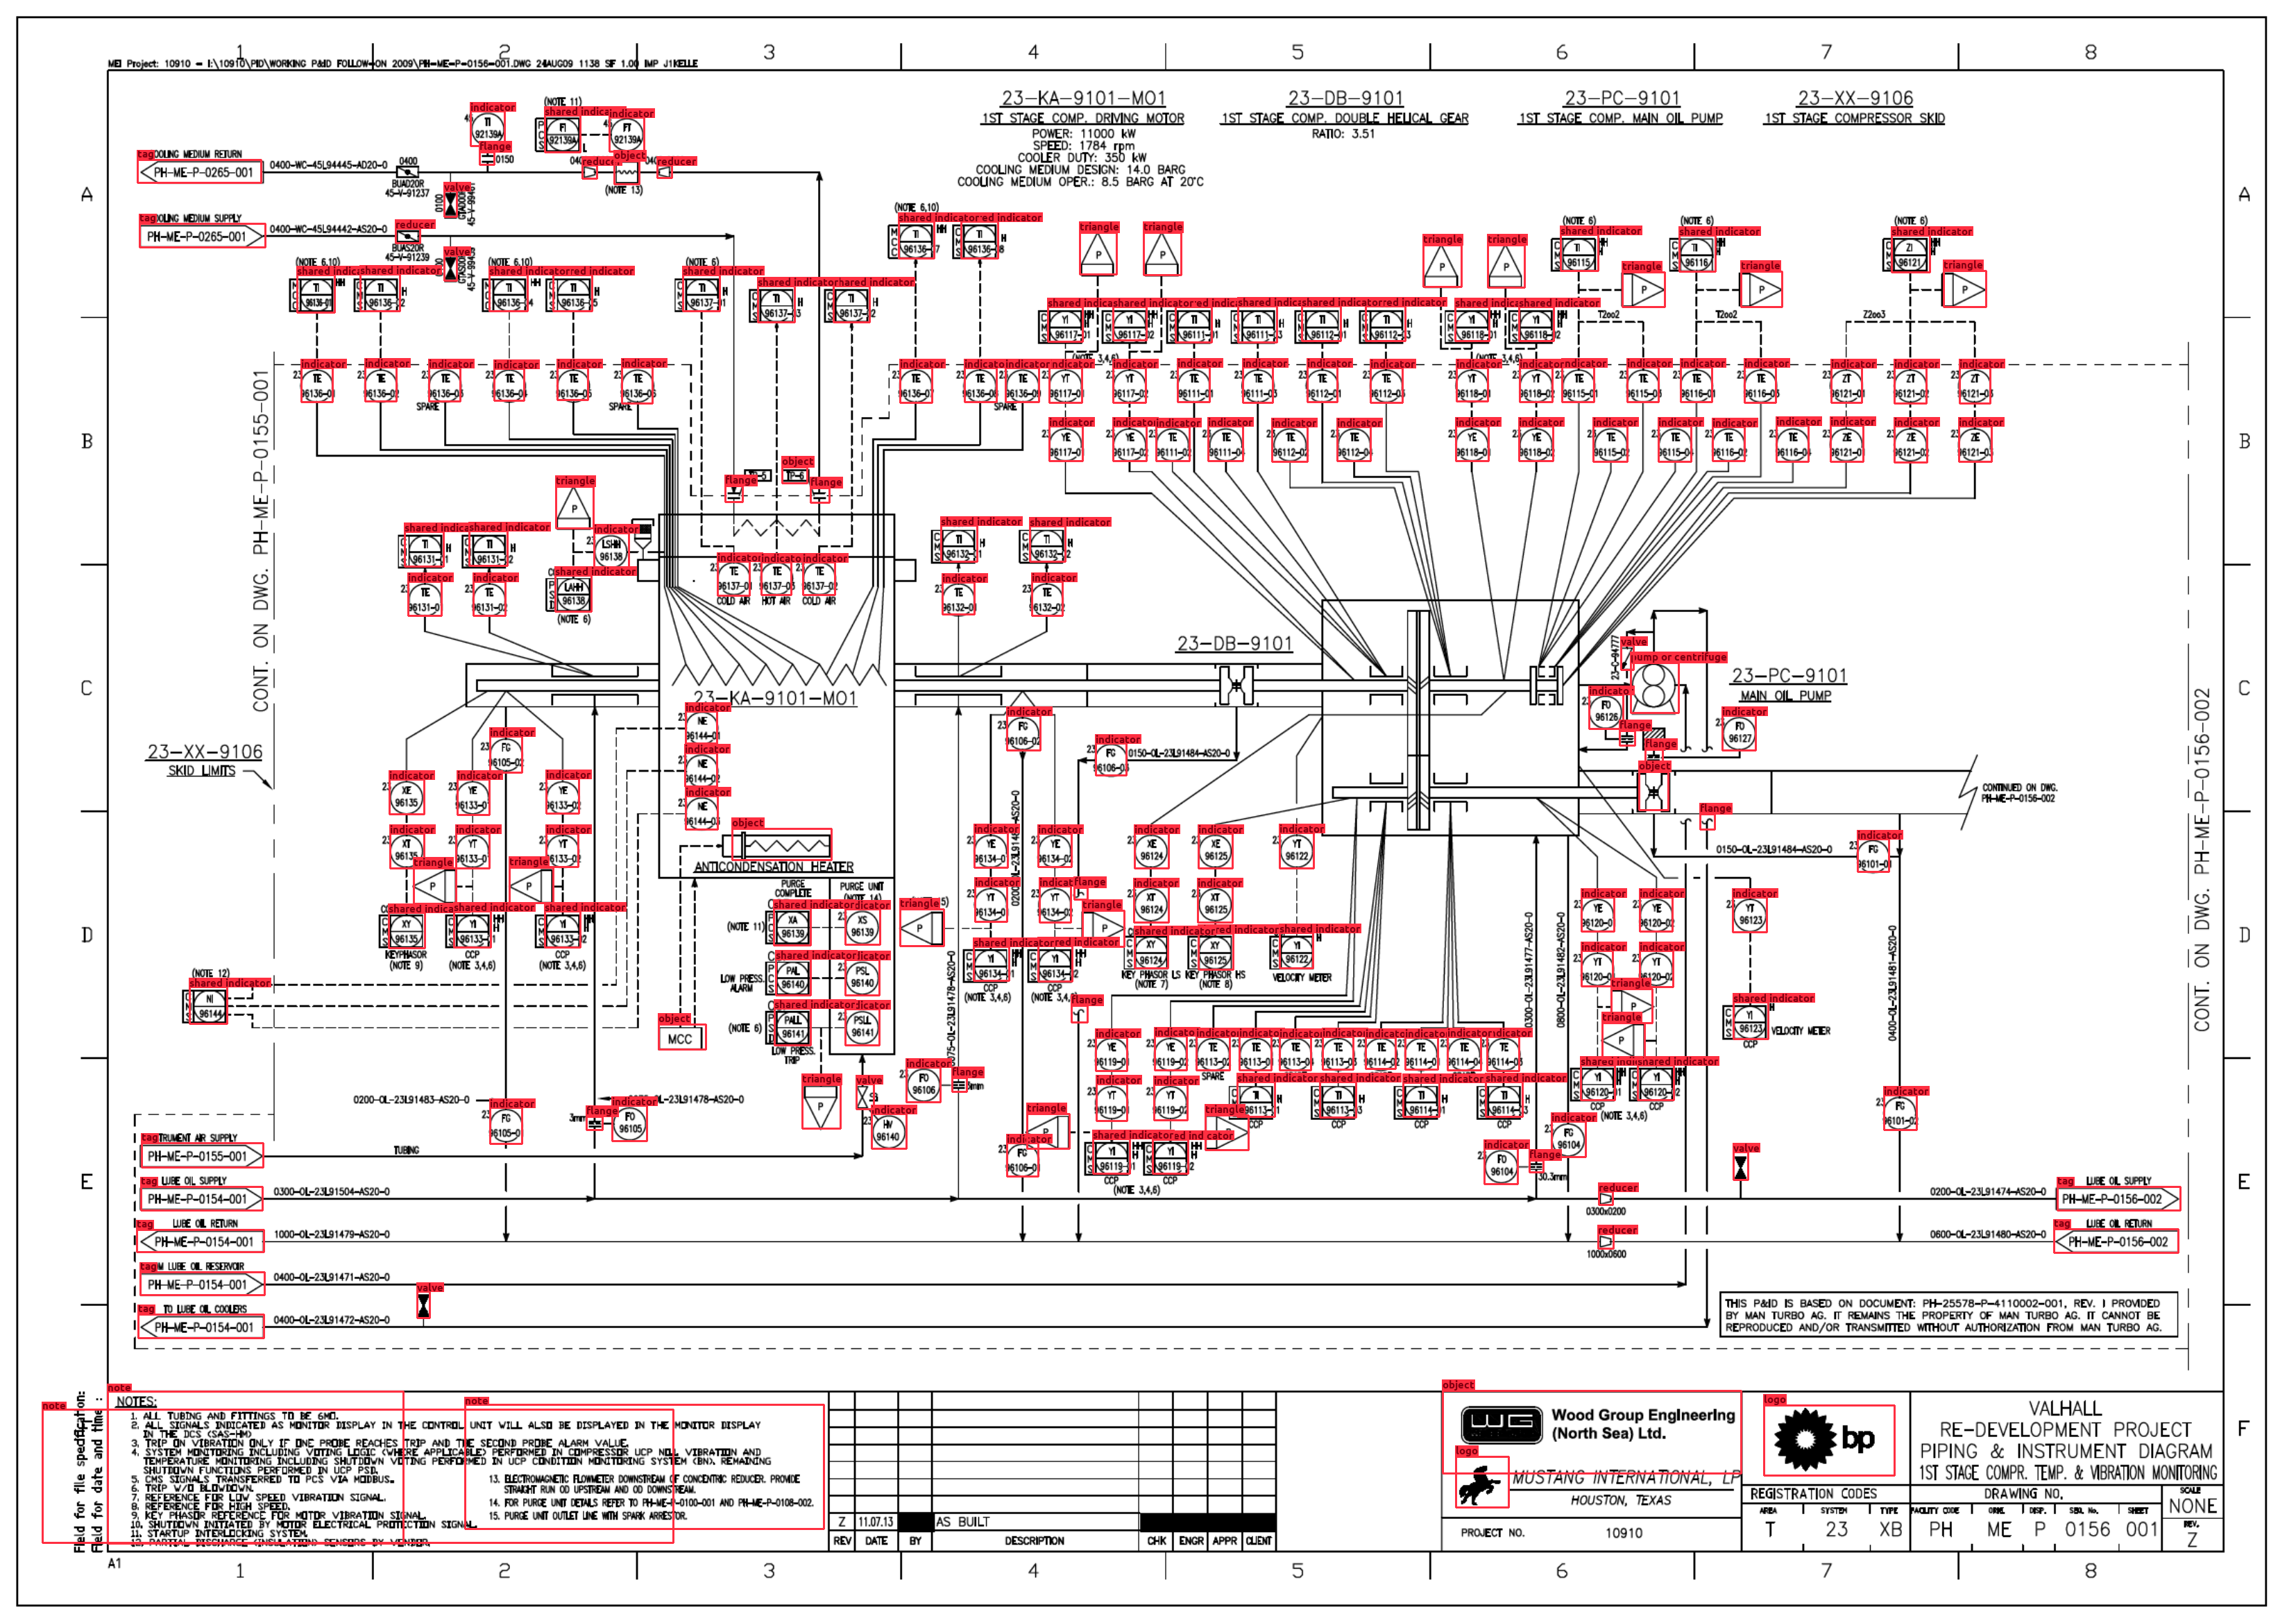

In [8]:
draw_bbox(pnid_img, result)

## Find similar objects from a template within the same P&ID
The `/findsimilar` endpoint takes at least two arguments `fileId` and `template` with the `boundingBox` and `type`. Here we show how to find the objects similar to the shared indicator specified.

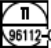

In [9]:
template ={
    'boundingBox': {
        'xMax': 0.5839555757026292,
        'xMin': 0.5684496826835902,
        'yMax': 0.2116289012398461,
        'yMin': 0.1911073108165883},
    'type': 'shared indicator'}
x_max, x_min, y_max, y_min = template["boundingBox"].values()
width, height = pnid_img.size
pnid_img.crop((
    int(x_min*width),
    int(y_min*height),
    int(x_max*width),
    int(y_max*height)
))

In [10]:
findsimilar_url = f"{api_url}/findsimilar"
post_body = {
    "fileId": file_id,
    "template": template
}
res = c.post(url = findsimilar_url, json = post_body)
job_id = json.loads(res.text)["jobId"]
print("jobId:", job_id)

jobId: 3342884671841622


In [11]:
%%time
res = c.get(url = f"{api_url}/{job_id}")

while json.loads(res.text)["status"] not in ["Completed", "Failed"]:
    time.sleep(1)
    print(json.loads(res.text)["status"])
    res = c.get(url = f"{api_url}/{job_id}")


result = json.loads(res.text)["items"]
print(f"found {len(result)} objects")
print("The first object parameters:")
pp.pprint(result[0])

Queued
Running
Running
Running
Running
Running
Running
found 34 objects
The first object parameters:
{ 'boundingBox': { 'xMax': 0.5838235294117647,
                   'xMin': 0.5682352941176471,
                   'yMax': 0.2113144758735441,
                   'yMin': 0.19093178036605657},
  'score': 1.0,
  'type': 'shared indicator'}
CPU times: user 33.2 ms, sys: 6.43 ms, total: 39.6 ms
Wall time: 7.31 s


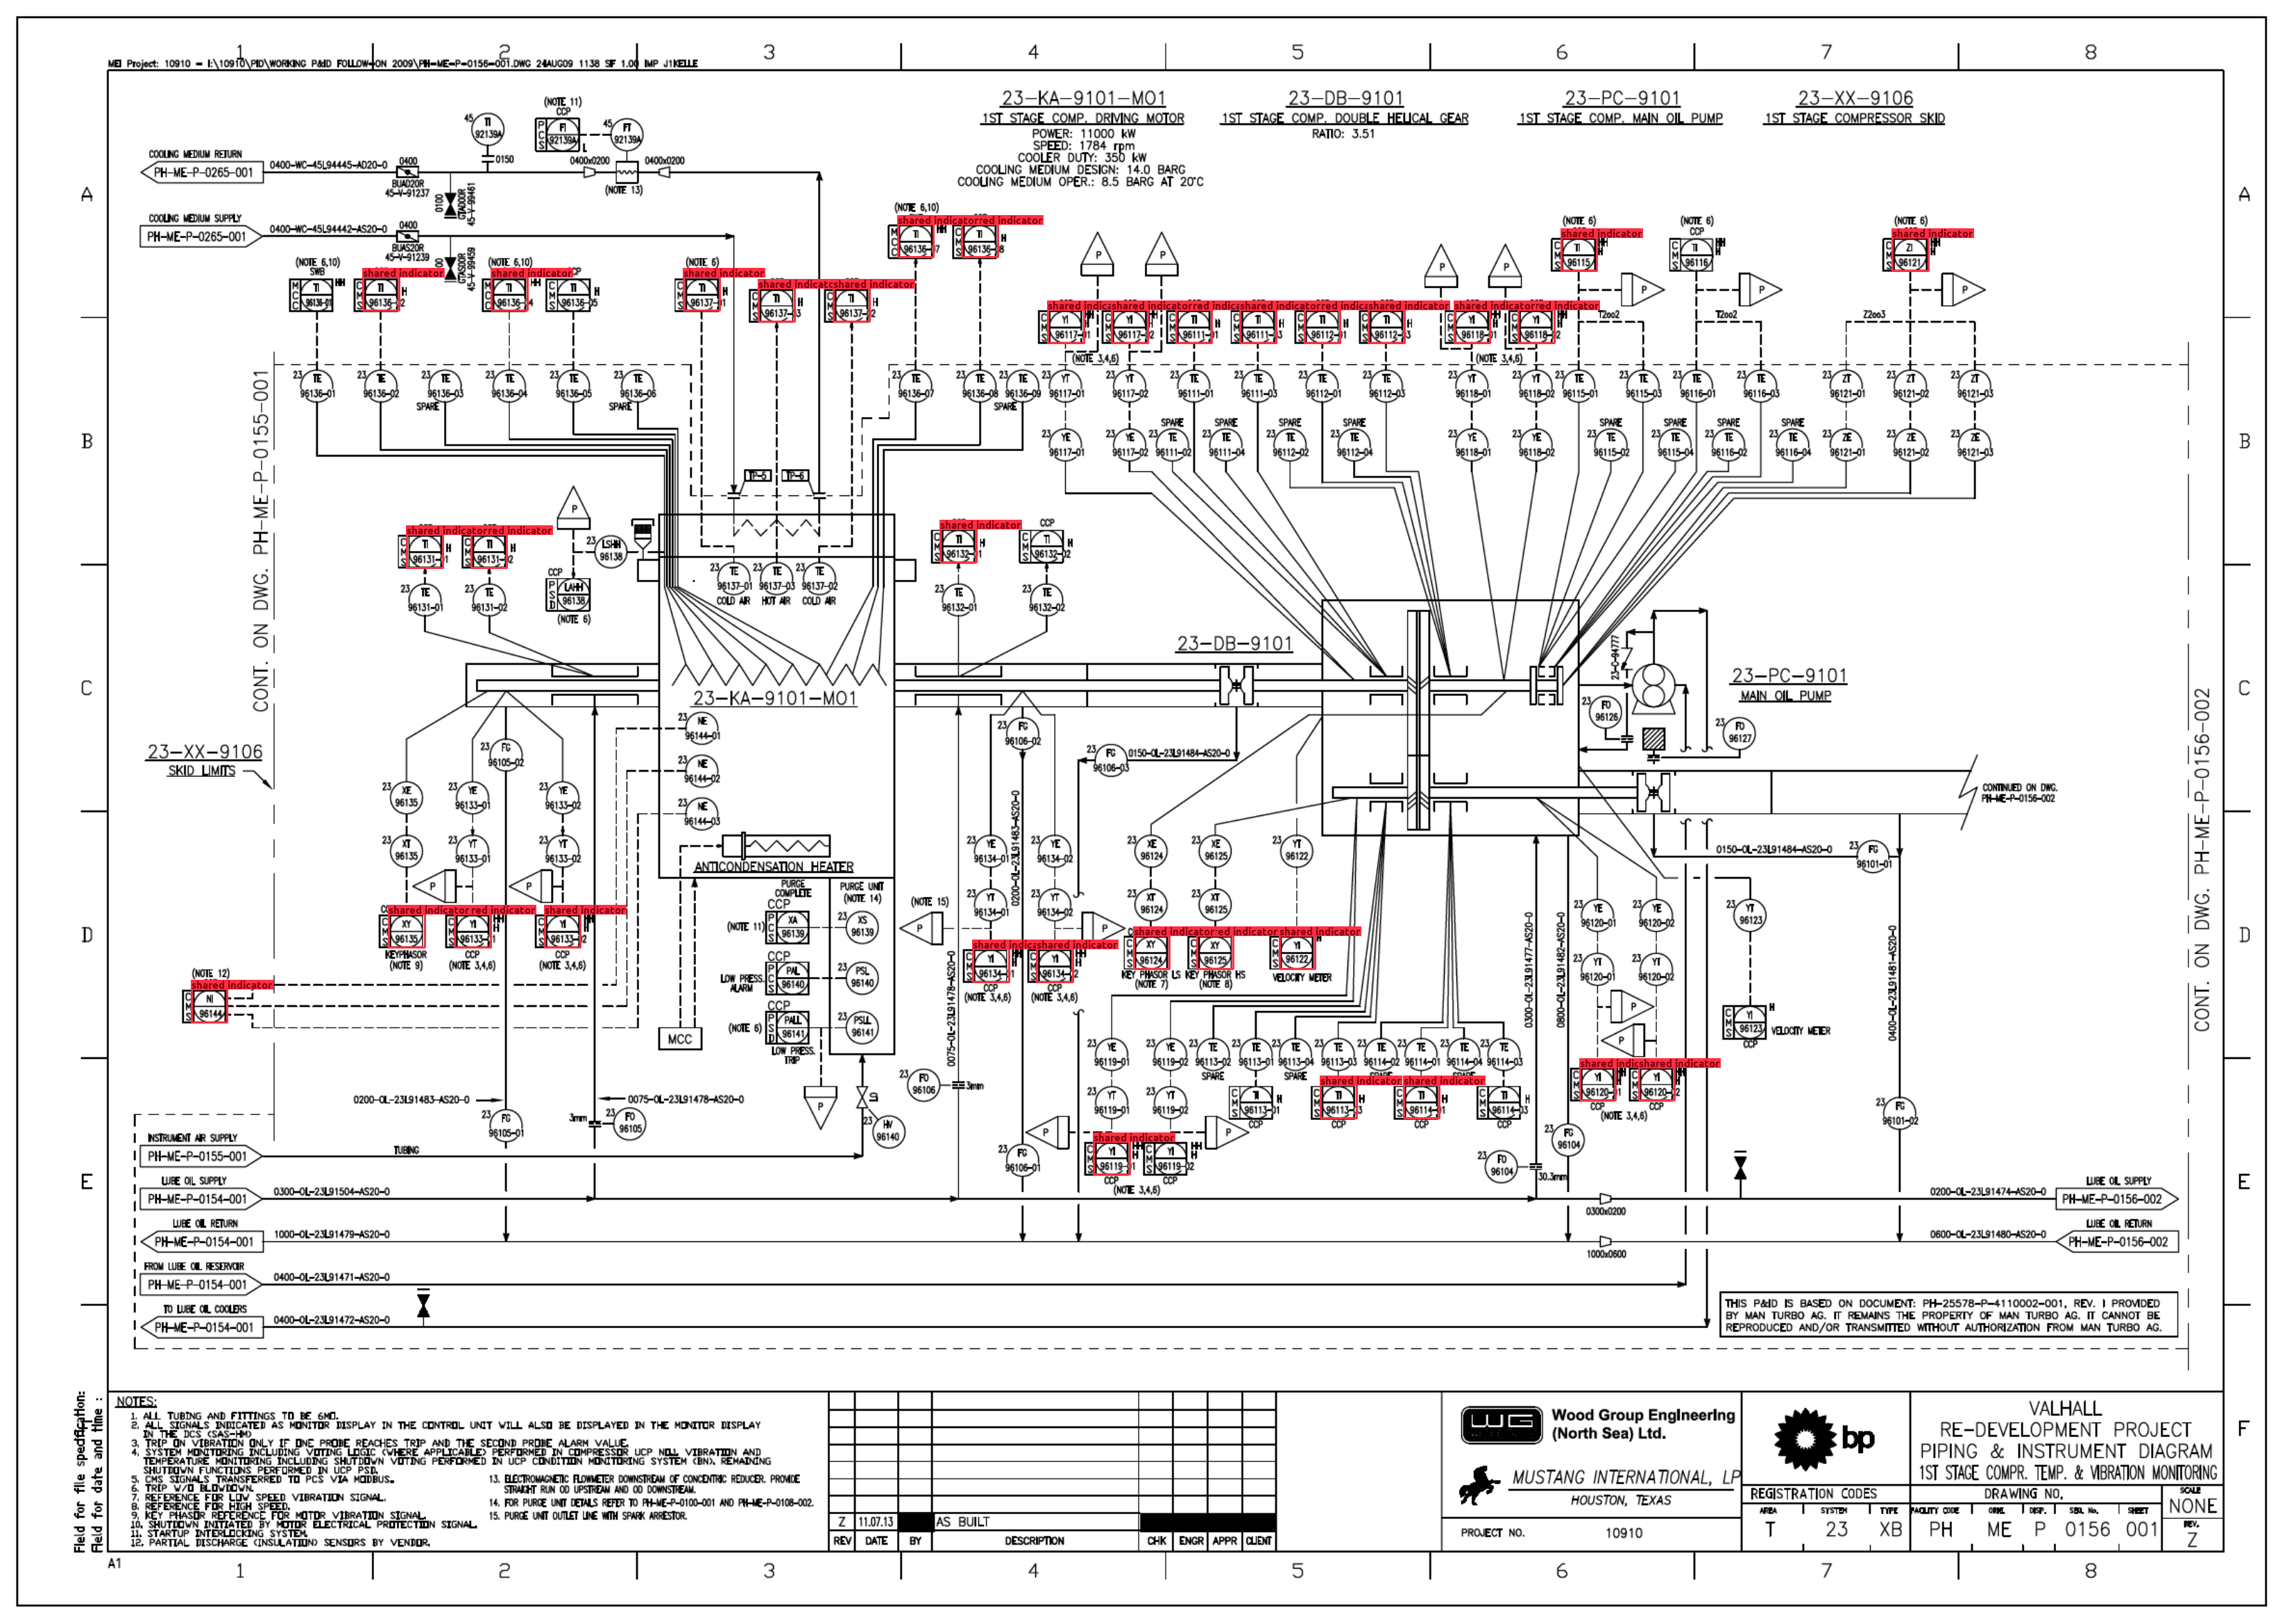

In [12]:
draw_bbox(pnid_img, result)

## Find objects similar to an object in a file from other P&ID files
Here we want to find objects from file `1296220000699223` that are similar to the above `template` from file `230063753840368` 

In [55]:
template["fileId"] = 230063753840368 # specify which files to extract the template

batchfindsimilar_url = f"{api_url}/batchfindsimilar"
post_body = {
    "fileIds": [1296220000699223, 2240135229528595, 230063753840368, 2694497441923100], # a list of fileIds to find similar objects from
    "template": template
}
res = c.post(url = batchfindsimilar_url, json = post_body)
job_id = json.loads(res.text)["jobId"]
print("jobId:", job_id)

jobId: 1102447417952359


In [56]:
%%time
res = c.get(url = f"{api_url}/batchfindsimilar/{job_id}") 
# Note the route to retrieve the results are different from /findobjects and /findsimilar due to the different response format

while json.loads(res.text)["status"] not in ["Completed", "Failed"]:
    time.sleep(1)
    print(json.loads(res.text)["status"])
    res = c.get(url = f"{api_url}/batchfindsimilar/{job_id}")


result = json.loads(res.text)["items"]
for item in result:
    print(f"found {len(item['objects'])} objects in fileId {item['fileId']}")
    
print("The first object parameters:")
pp.pprint(result[0]["objects"])

Queued
Queued
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
found 14 objects in fileId 1296220000699223
found 0 objects in fileId 2240135229528595
found 65 objects in fileId 230063753840368
found 0 objects in fileId 2694497441923100
The first object parameters:
[ { 'boundingBox': {'xMax': 787.0, 'xMin': 734.0, 'yMax': 892.0, 'yMin': 843.0},
    'score': 1.0,
    'type': 'shared indicator'},
  { 'boundingBox': { 'xMax': 2032.0,
                     'xMin': 1979.0,
                     'yMax': 1262.0,
                     'yMin': 1213.0},
    'score': 0.950340211391449,
    'type': 'shared indicator'},
  { 'boundingBox': { 'xMax': 2129.0,
                     'xMin': 2076.0,
                     'yMax': 1149.0,
                     'yMin': 1100.0},
    'score': 0.9488543272018433,
    'type': 'shared indicator'},
  { 'boundingBox': { 'xMax': 2097.0,
                     'xMin': 2044.0,
                     'yMax': 1440.0,
                